# **STAT 301 Final Report**

#### Group 10: Stellar Shar, Charles Deng, Ibrahim Sajid, Kevin Li

## Title here: Predicting Restaurant Ratings: An Analysis of DoorDash Data in Canada

In [ ]:
library(readr)
library(dplyr)
library(tidyverse)
library(tidyr)
library(leaps)
library(ggplot2)
library(tidymodels)
library(yardstick)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ r

## 1. Introduction

Online food delivery has become a huge part of how we eat today. It's not just about convenience anymore; for many people, it's an everyday necessity. The industry is growing fast, about 9% each year, and could be worth nearly $2 trillion by 2029 according to recent research (Mohamadabadi et al., 2024). One of the most important things customers look at when ordering is the star rating. Research shows people trust these ratings almost as much as personal recommendations (Selvaraj & Nallasivam, 2023).

This got us thinking: Could we predict a restaurant's star rating just by looking at basic information like its price range, how many reviews it has, how far it delivers, and what city it's in? Using real data from DoorDash in Canada, we're trying to build a model that does exactly that. We're not trying to figure out why certain restaurants get better ratings (that would require different methods), but rather see if we can make accurate predictions based on what we can observe.

This approach builds on what we know from previous studies about how important ratings are in food delivery apps, while focusing on a practical prediction problem that could help both the platforms and restaurant owners. The idea is that if we can predict ratings well, it might help restaurants understand what factors matter most to customers, and help platforms improve their recommendation systems.

**Research Question**: Can we accurately predict a restaurant's star rating (range from 1 to 5)on DoorDash using available features including price range (range from 1 to 4 dollar signs), delivery distance (in miles), number of reviews, and the city? Which combination of these features gives the most accurate predictive model?

## 2. Methods and Results

#### Part A: Exploratory Data Analysis (EDA)

The dataset we use is [Food Delivery in Canada (DoorDash)](https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash), with variables listed in the table below. It contains data on food delivery orders in Canada, focusing on restaurants with under 30-minute delivery times using iconic downtown addresses for each city on the DoorDash platform. The dataset has 9 variables and 3,290 observations, including order-related information such as restaurant details, delivery distance, price range, and more. These data are collected from DoorDash's public website without experimental manipulation, making this an observational dataset.

| **variable**       | **type**       | **description**                                                                 |
|--------------------|----------------|---------------------------------------------------------------------------------|
| restaurant         | text           | Name of the restaurant.                                                         |
| url                | text           | Restaurant menu page URL.                                         |
| distance           | numeric        | Distance from the order location to the restaurant (in miles).                  |
| star               | numeric        | Star rating of the restaurant (out of 5).                               |
| num_reviews        | numeric        | Number of reviews for the restaurant.                                           |
| city               | categorical    | City where the order is placed (levels: Brampton, Calgary, Edmonton, Montreal, Ottawa, Toronto, Vancouver, Winnipeg).                                              |
| price              | categorical    | Price range of the restaurant (levels expressed in 1 to 4 dollar signs).                        |
| category_1         | text           | Primary cuisine type (e.g., indian, chinese, bakery, fast food).                |
| category_2         | text           | Secondary menu category (e.g., biryani, burgers, noodles, vegetarian).          |

Dataset Citation:
Data source: Satoshi_S. (2022). Food delivery in Canada (Door Dash) [Data set]. Kaggle. https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash

In our analysis, we will exclude variables like restaurant name, URL, and category 1 and 2. Since they are either not directly related to predicting star ratings or lack clarity in what they represent. 

Moreover, we classified cities into two groups evenly based on their **population**: small cities ($x_i$ = 0) and big cities ($x_i$ = 1). Cities like Vancouver, Calgary, Toronto, and Montreal will be considered big cities, and the rest will be small cities.

As well, due to the low number of observations in the higher price ranges (three dollar signs and above), we combined them into a single category labeled “$$$+”.

In [ ]:
# Contributor: Stellar Shar
# Load data
url <- "https://raw.githubusercontent.com/KevinL002/STAT_301_group_10/refs/heads/main/cleaned_full_data.csv"

dataset <- read_csv(url, show_col_types = FALSE)
colnames(dataset)[1] <- "index"

In [ ]:
# Contributor: Stellar Shar
# Size of dataset
cat("Size of dd_delivery\n")
cat("Number of rows:", nrow(dataset), "\n")
cat("Number of columns:", ncol(dataset), "\n")

In [ ]:
# Contributor: Stellar Shar
# Explore the columns in the dataset
cat("Explore the columns in the dataset\n")
for (i in 1:ncol(dataset)) {
  col_name <- colnames(dataset)[i]
  col_type <- class(dataset[[i]])
  cat(col_name, ":", col_type, "\n")
}

In [ ]:
# Contributor: Stellar Shar
# Check for missing values in each column
cat("Check for missing values in each column\n")
missing_values <- colSums(is.na(dataset))
cat("Missing values per column:\n")
print(missing_values)

In [ ]:
# Contributor: Charles Deng
# Data Processing
cleaned_data <- dataset %>%
    mutate(price_range = fct_collapse(price_range, "$$$+" = c("$$$", "$$$$"))) %>% 
    mutate(city_size = case_when(city %in% c("Vancouver", "Calgary", "Toronto", "Montreal") ~ "Big City", 
                                 TRUE ~ "Small City")) %>%  # Classify city size by their population
    select(-1, -2, -3, -city, -category_1, -category_2) %>%  # Select useful variables
    select(star, distance, num_reviews, price_range, city_size) %>% # Move the response to the first column
    mutate(city_size = factor(city_size)) %>%
    drop_na()

head(cleaned_data)

New names:
• `` -> `...1`


star,distance,num_reviews,price_range,city_size
<dbl>,<dbl>,<dbl>,<fct>,<fct>
4.0,0.90,640,$$,Small City
4.0,2.00,301,$$,Small City
4.2,1.00,890,$$,Small City
4.4,0.40,109,$,Small City
4.5,0.09,481,$$,Small City
3.7,0.90,730,$$,Small City


In [ ]:
# Contributor: Stellar Shar
# Check updated size of the cleaned dataset
cat("Check updated size of the cleaned dataset\n")
cat("Number of rows:", nrow(cleaned_data), "\n")
cat("Number of columns:", ncol(cleaned_data), "\n")

In [ ]:
# Contributor: Stellar Shar
# Explore the columns in the newly cleaned dataset
cat("Explore the columns in the cleaned dataset\n")
for (i in 1:ncol(cleaned_data)) {
  col_name <- colnames(cleaned_data)[i]
  col_type <- class(cleaned_data[[i]])
  cat(col_name, ":", col_type, "\n")
}

#### Part B: Visualization

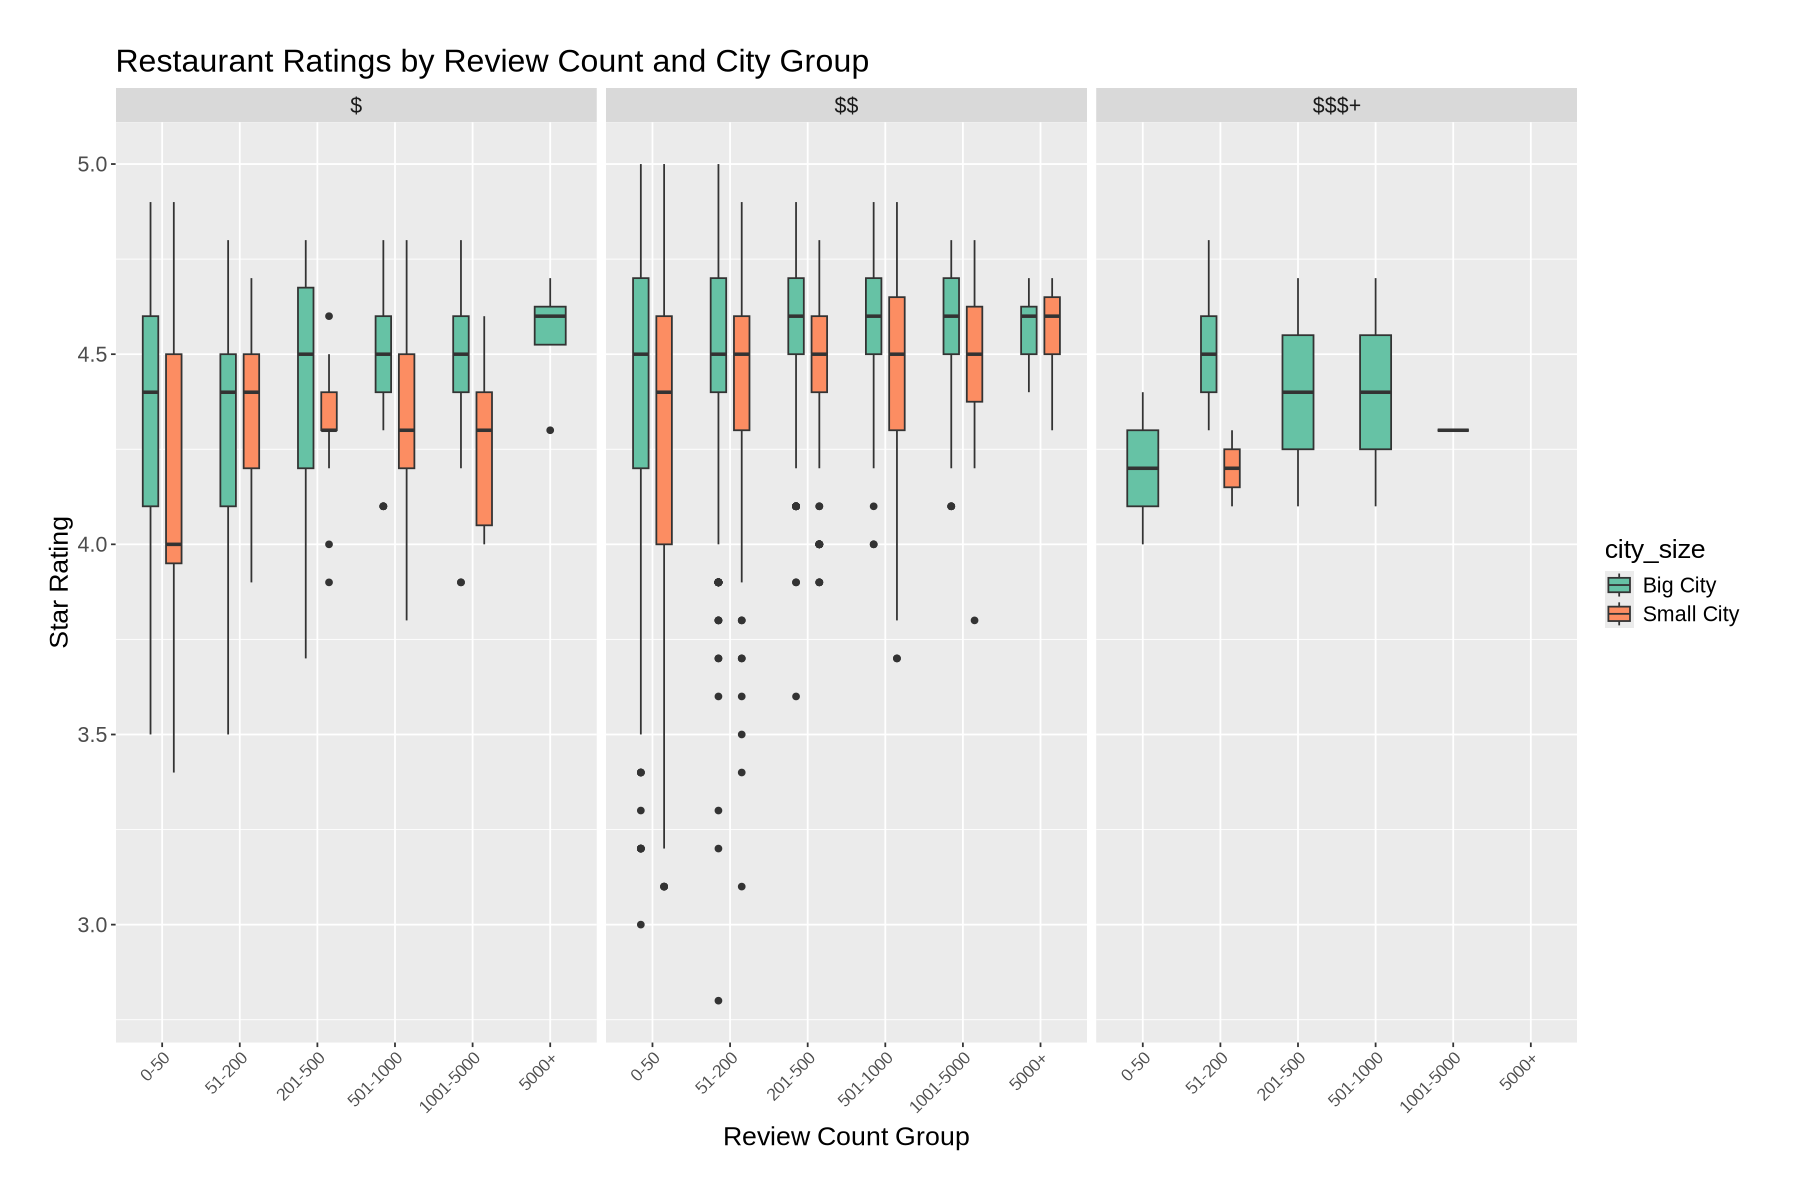

In [ ]:
# Contributor: Charles Deng
options(repr.plot.width = 15, repr.plot.height = 10)

visualize_data <- cleaned_data %>%
    mutate(review_group = cut(num_reviews,
                            breaks = c(0, 50, 200, 500, 1000, 5000, Inf),
                            labels = c("0-50", "51-200", "201-500", "501-1000", "1001-5000", "5000+")))

ggplot(visualize_data, aes(x = review_group, y = star, fill = city_size)) +
    geom_boxplot(position = position_dodge(width = 0.6), width = 0.4) +
    facet_grid(~ price_range) +
    labs(title = "Restaurant Ratings by Review Count and City Group",
         x = "Review Count Group",
         y = "Star Rating") +
    theme(text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
          plot.margin = margin(30, 30, 30, 30)) +
  scale_fill_brewer(palette = "Set2")

Figure 4: Heatmap of all inputs


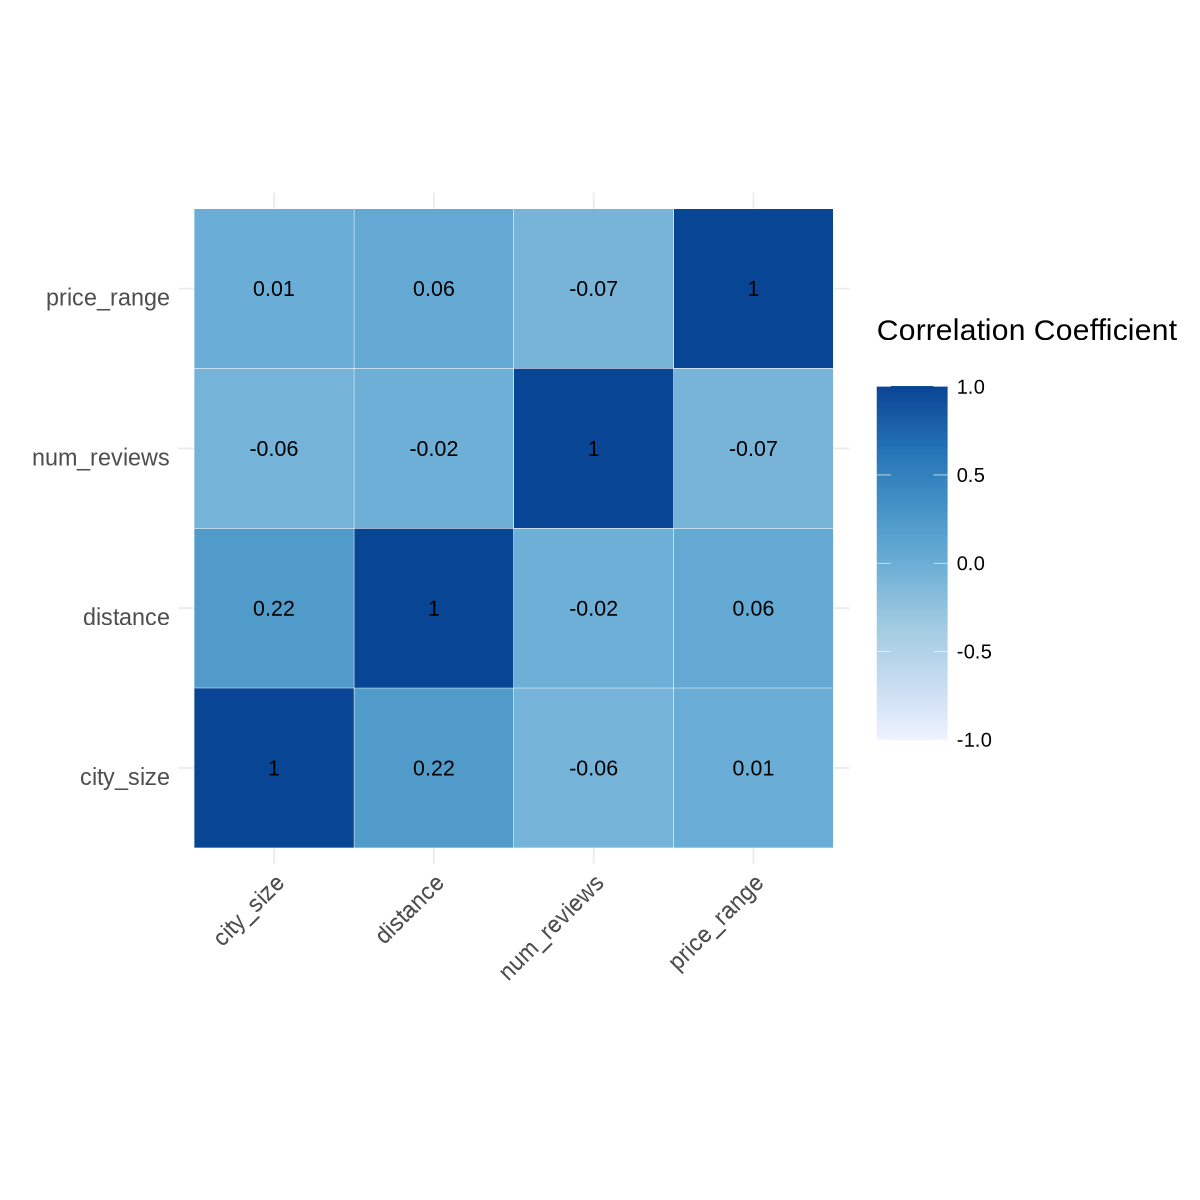

In [ ]:
# Contributor: Charles Deng
options(repr.plot.width = 10, repr.plot.height = 10)

# Calculate the correlation
corr_matrix <- cleaned_data %>%
  mutate(price_range = as.numeric(factor(price_range)),
         city_size = as.numeric(factor(city_size))) %>%
  select(-star) %>%
  select(where(is.numeric)) %>%
  cor() %>%
  as_tibble(rownames = 'var1') %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

# Plot the heatmap
corr_plot <- corr_matrix %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
                         palette = "Blues",
                         direction = 1, 
                         limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
corr_plot

cat("Figure 4: Heatmap of all inputs\n")

The correlation between these 4 variables is reasonable and all are less than 0.3, indicating low multicollinearity and the predictive power of each variable does not overlap. Therefore we move onto building the model without any further variable engineering.

#### Part C: Methods

`Summary` We aim to identify the best combination of inputs that yield the best prediction using stepwise selection with linear regression. 

### Why this method?
`Backward Stepwise Selection` 
- We use **backward selection** to filter true features that really matter. This method produces the simple regression model, which enhances **interpretability**.
- The process is **deterministic** and provides clear and consistent results.

`Linear Regression`
- We use linear regression because our **response variable**, star rating, is a **continuous variable** ranging from 1 to 5.
- We have **multiple explanatory variables** that may contribute to the variation in the star rating, and MLR will allow us to assess the relationship between these predictors and the response.

`Assumptions`are essential for the method selected:

Applying Linear Least Square Regression requires several assumptions to ensure validity:
- **Linearity**: The expected value of the response variable (star rating) is a linear combination of the explanatory variables.
- **Independence**: The errors are independent, i.e., $\mathbb{E}[\epsilon] = 0$.
- **Normality**: The errors (not the response itself) are normally distributed at each level of the covariates.
- **Equal Variance**: The standard deviation of the responses is equal for all levels of covariates (homoscedasticity).
- **Adequate Sample Size**: Assumes a sufficiently large sample size to ensure reliable estimation of the model parameters.

`Potential limitation and weaknesses`
- Interaction terms may introduce multicollinearity, leading to unstable standard errors.
- Stepwise selection is a greedy method that can overfit the training data; cross-validation is necessary to assess model performance.
- Including many interaction terms can reduce model interpretability.
- The model may be limited by the data itself, as star ratings can be high even with few reviews, suggesting nonlinearity or unobserved factors not captured by the available features.

#### Part D: Implementation of a proposed model: computational code and output

In [ ]:
# Set seed for reproducibility
set.seed(999)

#Split cleaned dataset into 70% testing data and 30% training data
data_split <- initial_split(cleaned_data, prop = 0.7, strata = star)
training_set <- training(data_split)
testing_set <- testing(data_split)

We use backward stepwise selection to find the best attributes for star rating prediction.  Using model fit criteria such as adjusted R-squared, the strategy begins with all variables and gradually eliminates the least helpful ones.  We chose this approach because it strikes a compromise between predictive strength and model simplicity, and it performs well when interpretability is crucial.

In [ ]:
# Contributor: Ibrahim Sajid
# Perform backward variable selection
backward_selection <- regsubsets(star ~ distance + num_reviews + price_range + city_size, 
                                 data = training_set, 
                                 nvmax = 4, 
                                 method = "backward")

backward_summary <- summary(backward_selection)

# The model size with the greatest adjr2
adjr2_max <- which.max(backward_summary$adjr2)

# Get the variables present in the model with greatest adjr2
selected_var <- names(which(backward_summary$which[adjr2_max, -1]))

cat("Table: Variables included in the model with the greatest adjr2\n")
print(selected_var)

backward_summary

Table: Variables included in the model with the greatest adjr2
[1] "num_reviews"         "price_range$$"       "city_sizeSmall City"


Subset selection object
Call: regsubsets.formula(star ~ distance + num_reviews + price_range + 
    city_size, data = training_set, nvmax = 4, method = "backward")
5 Variables  (and intercept)
                    Forced in Forced out
distance                FALSE      FALSE
num_reviews             FALSE      FALSE
price_range$$           FALSE      FALSE
price_range$$$+         FALSE      FALSE
city_sizeSmall City     FALSE      FALSE
1 subsets of each size up to 4
Selection Algorithm: backward
         distance num_reviews price_range$$ price_range$$$+ city_sizeSmall City
1  ( 1 ) " "      " "         " "           " "             "*"                
2  ( 1 ) " "      " "         "*"           " "             "*"                
3  ( 1 ) " "      "*"         "*"           " "             "*"                
4  ( 1 ) "*"      "*"         "*"           " "             "*"                

The number of reviews, price range, and city size were the most significant predictors of restaurant star ratings, according to the findings of the backward selection process.  num_reviews, a mid-range pricing (price_range$$), and whether the restaurant was situated in a small city were all included in the ideal three-variable model, indicating that evaluations are influenced by both popularity and location factors.

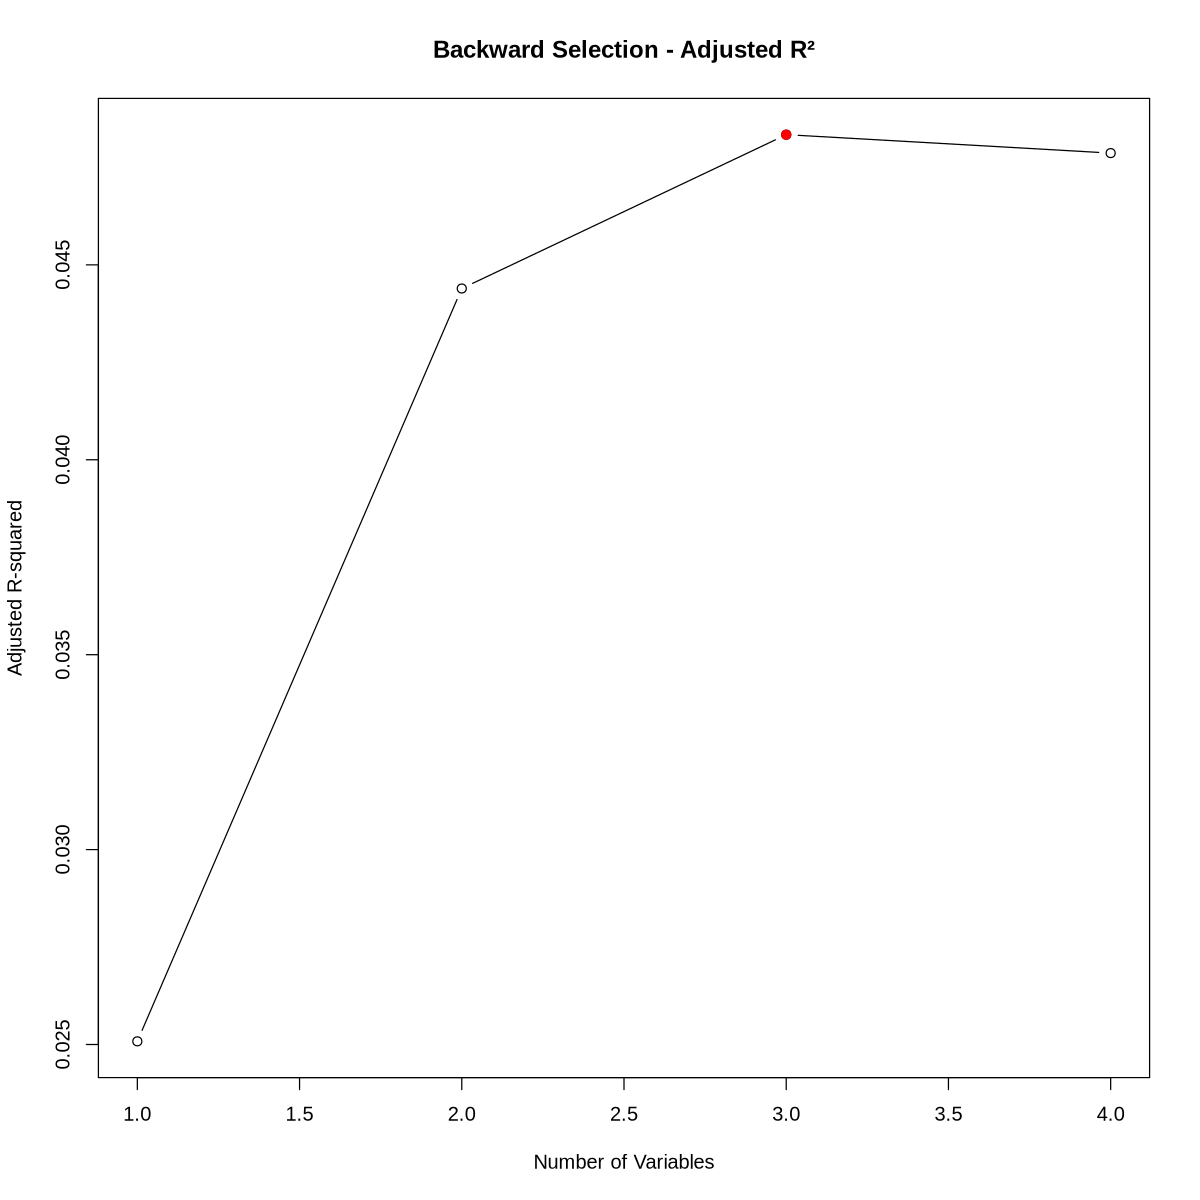

In [ ]:
# Contributor: Ibrahim Sajid
# Plot the Adjusted R² values for each model size from backward selection
par(bg = "white", col.axis = "black", col.lab = "black", col.main = "black")

plot(backward_summary$adjr2, type = "b", 
     xlab = "Number of Variables", ylab = "Adjusted R-squared", 
     main = "Backward Selection - Adjusted R²")
best_size <- which.max(backward_summary$adjr2)
points(best_size, backward_summary$adjr2[best_size], col = "red", pch = 19)

This plot shows how the adjusted R-squared changes as more variables are included in the model using backward stepwise selection. The peak occurs at three variables, indicating the optimal balance between model complexity and explanatory power. Including more than three variables slightly reduces adjusted R-squared, suggesting that additional predictors do not meaningfully improve the model and may add unnecessary complexity.

In [ ]:
# Fit a multiple linear regression model to predict 'star' ratings on training data
mlr_model <- lm(star ~ num_reviews + price_range + city_size, data = training_set)

mlr_gof <- glance(mlr_model) %>% round(3)
mlr_gof

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.05,0.048,0.271,24.006,0,4,-208.087,428.175,461.254,134.62,1827,1832


With an R-squared of 0.05 and an adjusted R-squared of 0.048 for the training set, the multiple linear regression model only partially explains the variance in restaurant star ratings. The model is statistically significant (F = 24.006, p < 0.001), indicating that the predictors together make a considerable contribution to the response variable, even with the low explanatory power.

We employed root mean squared error (RMSE), mean absolute error (MAE), and R-squared as metrics to assess the multiple linear regression model's performance on the test set.  With an RMSE of 0.276 and an MAE of 0.204, the model produced star ratings with a comparatively low average prediction error.  Nonetheless, the R-squared value was around 0.050, indicating that the model only accounts for roughly 4% of the ratings' variation. This is in line with previous findings and emphasizes the features' poor predictive ability.

In [ ]:
# Generate predictions on the testing set using the trained MLR model
predictions <- predict(mlr_model, newdata = testing_set)

# Create a data frame with actual and predicted values
results <- data.frame(
  truth = testing_set$star,
  estimate = predictions
)

# Calculate regression performance metrics on the model's predictions
metrics(results, truth = truth, estimate = estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.27618510
rsq,standard,0.02282241
mae,standard,0.20411635


## 3. Discussion

##### **Results/Implications**

1. RMSE:
Root Mean Squared Error measures the average size of the errors between predicted and observed values. In our case, the RMSE is 0.2778880. This indicates that, on average, our model's predictions are 0.276 star ratings off the actual value recorded in the dataset. In the context of our research question, the RMSE is relatively low, with a 0.276 error being less than a 1-star error in star rating predictions. 

2. R^2:
The R-squared of a model measures the explanatory power of the model. Specifically, it measures how much of the variation in the dependent variable is explained by our model. In our case, the R-squared of 0.023 is very low. This indicates that the model was only able to explain around four percent of the variation in the dependent variable. This suggests that the model is either a poor fit for our research question or that the model was not trained on sufficient data to give it enough information to have good explanatory power. 

3. MAE:
The Mean Absolute Error is a measurement similar to RMSE, with the main difference being that MAE does not emphasize large errors that the model makes (essentially it does not punish outliers as harshly). The MAE for our model was 0.204. This indicates that on average, and without penalizing outliers, the model's prediction is 0.204 star ratings off the actual recorded value in the testing dataset.

##### Answer to our research question:

Given the limitations of the dataset, the LR model did a relatively good job of predicting the star rating for restaurants. While an average error of 0.27 is not minuscule, a difference of 0.27 or even 0.3 on a star rating will not significantly affect how a customer judges whether a restaurant is good or bad. The main variables of interest that contributed the most to the model’s predictive power were given by the backward stepwise selection, and they are the following: Number of reviews, price range, and city size.

##### Expectations

Overall, the low explanatory power of the model was expected. This is because of the extremely limited information contained in the dataset. Keep in mind, our model was restricted because the dataset only contained 4 reasonably consistent variables, (price range, city_size, distance, and number_reviews). Furthermore, certain variables, such as distance, were poorly defined and inconsistently recorded. However, despite the low explanatory power of the model, the model's predictive power was relatively strong, given that the RMSE was less than 1 star point, indicating that on average, the model would be able to predict the star rating of a restaurant within 1 star rating.

##### Improvements

Firstly, the main issue with our model would be the lack of information and data used to train the model. If we were to have more consistent and better documented data, such as consistent data on the type of food served, number of orders, portion sizes, wait time, we would be able to construct a model that better explains and predicts star ratings. Furthermore, the choice of model, namely Linear Regression could be swapped out for a better model, this is because Star Rating (our dependent variable), is not necessarily numerical. Rather, Star rating is an integer measurement that could be interpreted as ordinal, given that 5 stars is ordered higher and better than those below it. For example, an Ordinal Logistic Regression model could arguably be a better fit for the question we have.

##### Future Questions and Research

Future research that is built upon the findings here could shift their focus towards understanding customer demographics and/or the impact social media or other online platforms have on the star ratings of a restaurant. For example, elderly and youths may have different preferences, and this could affect the star rating of a restaurant that specifically targets or caters to a certain demographic group. Furthermore, given the online nature of Doordash, social media will have a noticeable impact on the popularity, and indirectly on the star rating of a restaurant. It would be interesting to see how the virality of a restaurant affects its overall performance and ratings.

## 4. References

Dataset Citation:
Data source: Satoshi_S. (2022). Food delivery in Canada (Door Dash) [Data set]. Kaggle. https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash

Mohamadabadi, T. A., Nazarian-Jashnabadi, J., Daryani, M. A., Al-Rashid, M. A., & Campisi, T. (2024). Factors affecting online customer experience of food delivery services during crisis: TISM and Delphi techniques. *Sustainable Futures*, 100408. https://doi.org/10.1016/j.sftr.2024.100408

Selvaraj, C., & Nallasivam, A. (2023). Reflection of star ratings on online customer reviews; its influence on consumer Decision-Making. In *Lecture notes in networks and systems* (pp. 107–128). https://doi.org/10.1007/978-981-19-6634-7_9